# Sistemi Complessi per la Fisica del Clima - Lorenzo Amir Nemati Fard


## Stochastic resonance in climatic change
##### Roberto Benzi, Giorgio Parisi, Alfonso Sutera & Angelo Vulpiani

https://doi.org/10.3402/tellusa.v34i1.10782 (Parisi)

https://npg.copernicus.org/articles/17/431/2010/npg-17-431-2010.pdf (Benzi)

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.integrate import odeint
import sdeint

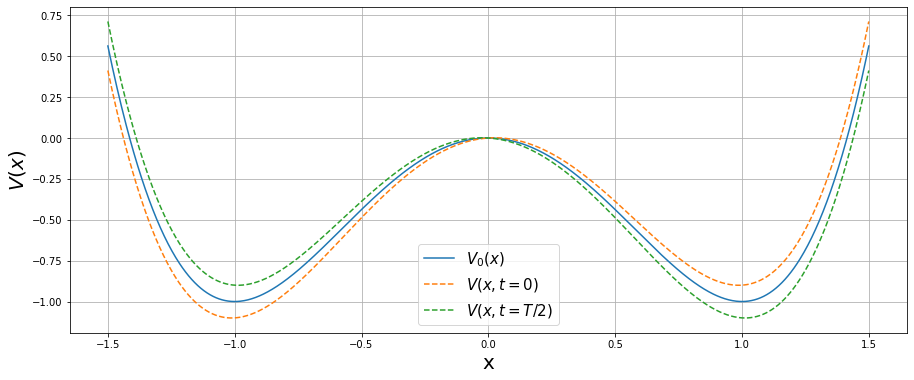

In [2]:
Vb = 1
l = 1
eps = 0.1

def V0(X):
    return 4*Vb*( -(X**2)/(2*l**2) + (X**4)/(4*l**4) )

t = 0

xx = np.linspace(-l*1.5, l*1.5, 1000)

plt.figure(figsize=(15,6))
plt.plot(xx, [V0(x) for x in xx], label = "$V_0(x)$")
plt.plot(xx, [V0(x)+eps*x for x in xx], linestyle="dashed", label = "$V(x,t = 0)$")
plt.plot(xx, [V0(x)-eps*x for x in xx], linestyle="dashed", label = "$V(x, t = T / 2)$")
plt.ylabel("$V(x)$", fontsize=20)
plt.xlabel("x", fontsize=20)
plt.grid()
plt.legend(prop={'size': 15})
plt.savefig("./Figures/Potential.png")

In [3]:
tmax = 50000
dt   = 0.1

nu = np.sqrt(8)*Vb / (np.pi*l*l) # time unit = Vb/l
w = 2*np.pi / 10000

D_opt = Vb/np.log(np.pi*nu/w)

X0 = 0 # Initial value


def RHS_perturbed(X,t):
    return 4*(Vb/l)*( (X/l) - (X/l)**3 - eps*np.cos(w*t) )

def RHS_unperturbed(X,t):
    return 4*(Vb/l)*( (X/l) - (X/l)**3 )

def sigma(T,t):
    return np.sqrt( 2*D_opt)
    
tt = np.arange(0, tmax+dt, dt)

TT_noise        = sdeint.itoint(RHS_unperturbed, sigma, X0, tt) #dy = f(y,t)dt + G(y,t)dW
TT_perturbation = odeint(RHS_perturbed, X0, tt) #dy = f(y,t)dt + G(y,t)dW
TT_resonance    = sdeint.itoint(RHS_perturbed, sigma, X0, tt) #dy = f(y,t)dt + G(y,t)dW

Tmax = max(TT_resonance)
Tmin = min(TT_resonance)


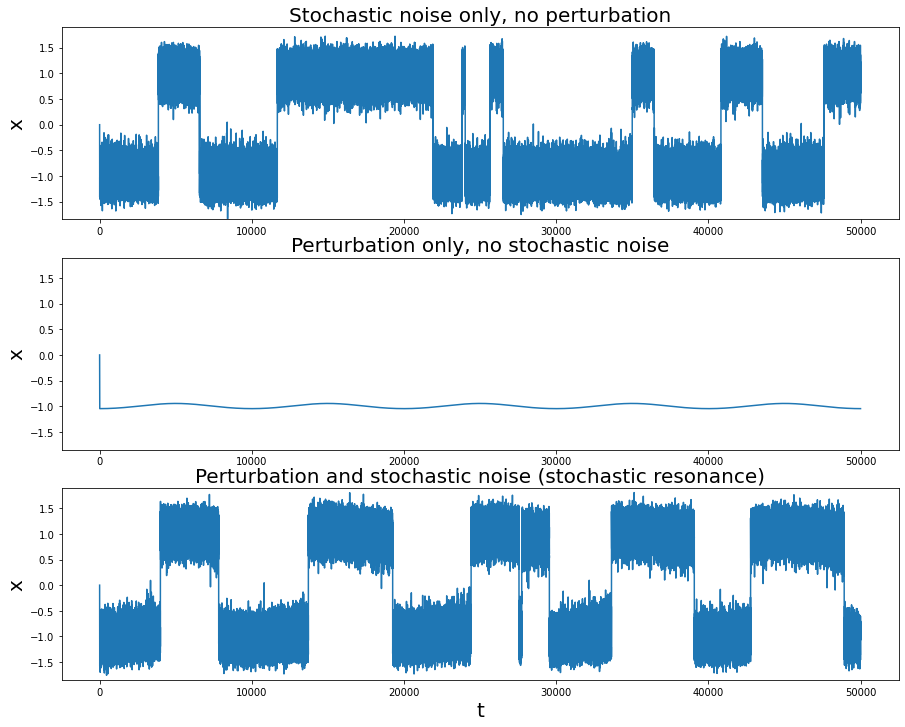

In [4]:
fig, ax = plt.subplots(3, 1, figsize=(15,12))

for axis in ax:
    axis.set_ylim(Tmin*1.05, Tmax*1.05)
    
ax[0].set_title('Stochastic noise only, no perturbation', fontsize=20)
ax[0].plot(tt, TT_noise)
ax[0].set_ylim(1.05*min(TT_resonance),1.05*max(TT_resonance))
ax[0].set_ylabel("x", fontsize=20)


ax[1].set_title('Perturbation only, no stochastic noise', fontsize=20)
ax[1].plot(tt, TT_perturbation)
ax[1].set_ylim(1.05*min(TT_resonance),1.05*max(TT_resonance))
ax[1].set_ylabel("x", fontsize=20)

ax[2].set_title('Perturbation and stochastic noise (stochastic resonance)', fontsize=20)
ax[2].plot(tt, TT_resonance)
ax[2].set_ylim(1.05*min(TT_resonance),1.05*max(TT_resonance))
ax[2].set_xlabel("t", fontsize=20)
ax[2].set_ylabel("x", fontsize=20)

plt.savefig("./Figures/simulation.png")

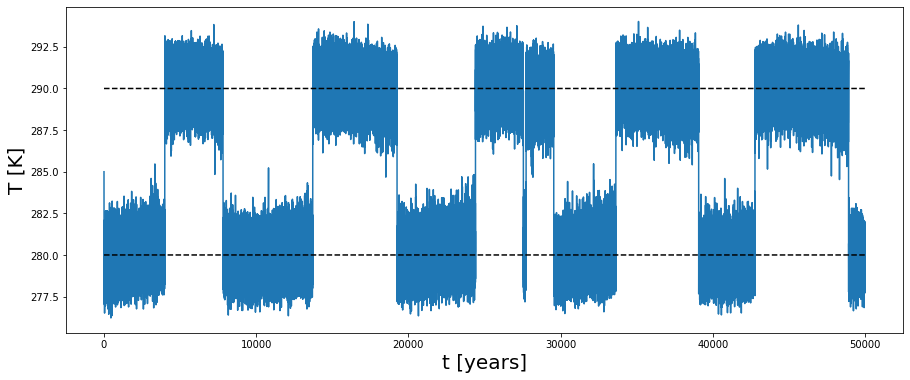

In [5]:
T2 = 285
DT = 5

TT = np.array([T2 + DT*x for x in TT_resonance])

plt.figure(figsize=(15,6))
plt.plot(tt, TT)
plt.plot(tt, [T2+DT for t in tt], linestyle="dashed", color ="k")
plt.plot(tt, [T2-DT for t in tt], linestyle="dashed", color ="k")
plt.xlabel("t [years]", fontsize=20)
plt.ylabel("T [K]", fontsize=20)
plt.savefig("./Figures/temperature.png")